In [2]:
from robobrowser import RoboBrowser as rbr
from googlesearch import search

import re as re
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import time


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\python\python36-32\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
browser=rbr(history=True)

This webscraper oraganizes discography information from bands pulled on google searchs, the scraped from the resulting websites. Currently, this only works on the darklyrics.com site and is customized for their html structure. However, fleixibility can be added later to use input regular expressions to parse data from whatever website the lyrics are on. 



Functions / Objects

All of these functions and objects live outside the main data class, but contribute to the data organization strategy. 

In [4]:
def scrape(site):
    try:
        browser.open(site)
        htmltext = browser.select('body')
        paragraphs = []
        for x in htmltext:
            paragraphs.append(str(x))
        htmltext=''.join(paragraphs)
        time.sleep(2)
        return htmltext
    except:
        print('Could not load' + site)
    
def pull_name(i, band_name):
    return re.search(band_name+'/(.*).html', i).group(1)

class album:
    def __init__(self, name, date):
        self.name=name
        self.date=date
        self.songs={}
        self.__dict__

    def make_song(self, lyrics, title_sep, lyrics_sep):
        title=re.search(re.compile(title_sep), lyrics).group(1)
        lyrs=re.search(re.compile(lyrics_sep), lyrics).group(1)
        #proects against picking up some garbage at the end of pages
        if not lyrs:
            pass
        else:
            #clean up the lyrics for easy searching later
            lyrs=re.sub('<br/>', '', lyrs)
            self.songs[title]=lyrs                   
        return self
    
    def word_freq(self, wordset=['The']):
        #create regex expression from the input list
        #for faster search
        srchex=''
        if len(wordset)==1:
            srchex=wordset[0]
        else:
            for idx, word in enumerate(wordset):
                if not idx==len(wordset)-1:
                    srchex+=(word+'|')
                else:
                    srchex+=(word)
        pattern=re.compile(srchex, re.IGNORECASE)
        
        return len(re.findall(pattern,''.join(self.songs.values())))
        

Main class that stores the discography information as well at the html content. This is the simplist case of the class which organizes and searches the discography. 

In [27]:

#main class for ogranizing the band data. Currently defaults to megadeth, 
#but should theoretically work for any metal band on darklyrics
class disco:
    def __init__(self,pages, band='megadeth',  searchLoad=20):
    
        self.raw_content=pages               
        self.albums={}                 
    
    def process_albums(self):
        lyr_sep=re.compile(r'class="lyrics">(.*)<div class="thanks"')
         #use regex to pull identifiers for the album/song look up table                 
        for content in self.raw_content:
           #date name for album info
            
            #structure mangment wasn't cosistent across the website, so we're gonna
            #pass over strucutres that aren't formed the way we want
            try:
                print(re.search('album: (.*)</h2>', content).group(1).split(' ('))
                title, year = re.search('album: (.*)</h2>', content).group(1).split(' (') 
                
                if title in self.albums.keys():
                    pass
                #initiate class for the album, slice of the last parenthesis in year
                alb=album(name=title, date=year[:-1])
                #remove end of lines for easier search
                con=re.sub('\n', ' ', content)
            
                #subset based on where the lyrics start so we can split the songs up
                con=re.search(r'class="lyrics">(.*)<div class=', con).group(1)
            
                #split and assing songs to the album later for look up
                for song in re.compile(r'name="[0-9]">|name="[0-9][0-9]">').split(con)[1:]: 
                    alb.make_song(lyrics=song, title_sep=r'[0-9].(.*)</a>', lyrics_sep='</h3>(.*)<h3>|</h3>(.*)<br/><div class')
                
                self.albums[title]=alb
            except:
                print ('Inconsistent page structure detected. Skipping page...')
   
    #search the discography with amatorized O(1) look up for different options, 
    #initialization may be slower than optimal, but this should free memory since the
    #dict doesn't live outside the function
    def search(self, Type='Album', Find='All'):
        #coercing to lower protects against user inputs
        if Type.lower()=='album': 
            searchops={"All": list(self.albums.keys()), 
                            'Any': random.choice(self.albums.keys()) 
                             }, 
            searchops.update(self.albums)
            return searchops[Find]
        elif Type.lower()=='song':
            #add any after initiation so we don't have to recompile list
            searchop={'All': [list(al.song.values()) for al in self.ablums.values()]}
            searchops['Any']=random.choice(searchops['All'])
            for albums in self.albums:
                searchops.update(ablums.songs)

        

In [6]:
#pull websites from google that cotain lyrics to scrape
site_list=search(query='darklyrics megadeth song lyrics', num=20, stop=4)
sites=[scrape(item) for item in site_list if re.search('megadeth/.*.html', item)]

c:\python\python36-32\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file c:\python\python36-32\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [28]:
f=disco(pages=sites)
f.process_albums()

['"Dystopia"', '2016)']
['"The World Needs A Hero"', '2001)']
['"Th1rt3en"', '2011)']
['"Cryptic Writings"', '1997)']
['"Rust In Peace"', '1990)']
Inconsistent page structure detected. Skipping page...
['"Super Collider"', '2013)']
['"The System Has Failed"', '2004)']
['"United Abominations"', '2007)']
['"So Far, So Good... So What !"', '1988)']
['"Killing Is My Business... And Business Is Good!"', '1985)']
['"Peace Sells... But Who\'s Buying?"', '1986)']
['"Countdown To Extinction"', '1992)']
Inconsistent page structure detected. Skipping page...
Inconsistent page structure detected. Skipping page...


In [18]:
#get data on the number of times a word realted to death was metioned in each album along 
#with the date so we can plot any changes in the use of the word
words=['dead', 'death', 'dying', 'died']
data=[{'Title':g.name, "Year":int(g.date), "Count":g.word_freq(words)} for g in f.albums.values()]
dats=pd.DataFrame(data).sort_values("Year")

#write orderer year indicies since pymc uses array index
dats['year_idx']=range(len(dats.Year))

Text(0.5,1,'Number of Words Related to \n Death in Megadeth Albums')

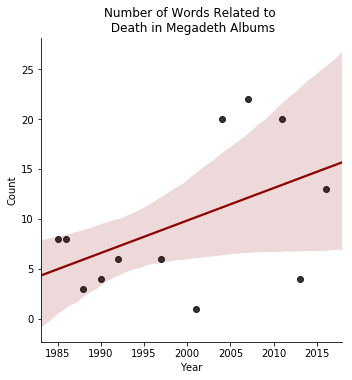

In [24]:
#make the plot hella metal
plot=sns.lmplot(x='Year', y='Count', data=dats, line_kws={'color': 'darkred'},
               scatter_kws={"color": "black"})
plot.ax.set_title('Number of Words Related to \n Death in Megadeth Albums')

In [25]:
#run a bayesian linear model to see if there's enough evidence to make
#any claims about these data
death_model=pm.Model()
with death_model:
    
    #linear model specifications
    b0=pm.Normal('b0', mu=0, sd=5)
    sig_b0=pm.HalfNormal('sig_b0', sd=2)
    b1=pm.Normal('b1', mu=0, sd=5)
    sig_b1=pm.HalfNormal('sig_b1', sd=2)
    
    mu=b0+b1*dats.year_idx
    
    #error for the model
    eps = pm.HalfCauchy('eps', 5)
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=eps, observed=dats.Count)
    

map_estimate = pm.find_MAP(model=death_model)
print (map_estimate)

logp = -49.213, ||grad|| = 0.00063993: 100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 702.37it/s]


{'b0': array(3.1898067), 'sig_b0_log__': array(-7.44976343), 'b1': array(1.09268678), 'sig_b1_log__': array(-7.44976343), 'eps_log__': array(1.79313539), 'sig_b0': array(0.00058158), 'sig_b1': array(0.00058158), 'eps': array(6.00826123)}


In [26]:
#we can pull log probilities of models with given parameters
#so wrap in a exponential function to get the probatility
model=np.exp(death_model.logp(map_estimate))
null=np.exp(death_model.logp({'b0': 3.1898067, 'sig_b0_log__': -7.44976343, 'b1': 0, 'sig_b1_log__': 0, 
                              'eps_log__': 1.79313539, 'sig_b0': 0.00058158, 'sig_b1': 0, 'eps': 6.008261239}))
BF=model/null
BF

2.906168663351679

We ran a bayesian linear regression to estimate the increase in the number of times megadeth uses words referring to death over time, or more specifically, the increase in the number of times they use the words death (dead, death, dying, dead) with each consecutive album. The model had normally distributed priors centered on 0 and with a standard deviation of 5 for both the intercept and slope. The model showed the greatest likelihood for an intercept of 3.189 and slope of 1.093. This was then compared to null model with the same parameters except that the slope was set to 0, suggesting that there was no change in usage of words related to death. The resulting Bayes Factor was 2.90. According to this analysis we have substatintail evidence to suggest that megadeth increases the number words related to death in their songs by 1.093 per year. 
